## **ParamsOptimiser**: Optimise your model parameters with MEDfl

In the field of machine learning, scientists frequently engage in a process of experimenting with diverse model configurations, adjusting parameters from one experiment to another. This iterative approach is aimed at uncovering the optimal combination of parameters that can enhance a model's performance. Particularly in the medical domain, datasets often exhibit a significant class imbalance, posing challenges in constructing models with robust performance. The quest for identifying the most suitable parameters becomes crucial in achieving optimal results for such imbalanced datasets.

With `MEDfl`, users are empowered to efficiently explore and discover the best parameter combinations that yield optimal model performance. The platform facilitates the intricate task of parameter tuning, enabling practitioners to navigate the complexities associated with imbalanced medical datasets. Through systematic experimentation and automated parameter optimization, `MEDfl` streamlines the process of finding configurations that enhance model efficacy, ultimately contributing to more effective and reliable machine learning models in the medical field. 

# 1. GRID SEARCH optimization
to optimise your model parameters usingn MEDfl grid search follow these steps:
1. **Define Parameter Configurations:**  a dictionary encapsulating diverse configurations of the selected parameters targeted for optimization. 

Parameter | Description             | ex.
----------| -----------------------|-------
hidden_dim|model hidden dimention | 'hidden_dim': [70 , 30]
lr        |Learning rate          |'lr': [0.001 , 0.001]
pos_weight|loss function weight    |  'pos_weight': [ 6 ,5]
max_epochs|max training iterations |    'max_epochs': [10, 20, 30] 


```python
param_grid = {
    'hidden_dim': [70 , 30], 
    'lr': [0.001 , 0.001], 
    'pos_weight': [ 6 ,5], 
    'max_epochs': [10, 20, 30] 
}
```

2. **Select a Scoring Metric:** Identify a scoring metric, crucial for ranking configurations according to their performance scores in relation to the chosen metric.

In [1]:
from Medfl.LearningManager.utils import global_params

import sys
sys.path.append(global_params['base_url'])

import os
os.environ['PYTHONPATH'] = global_params['base_url']


Imports

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd

# MEDfl imports 
from Medfl.LearningManager.params_optimiser import ParamsOptimiser

### Dataset
for this tutorial we will use the Mimic_train dataset

In [3]:
data = pd.read_csv( '../data/masterDataSet/Mimic_ouael.csv')

data.head()

,age,pao2fio2,uo,aids,hem,mets,admissiontype,bicarbonate,bilirubin,bun,gcs,hr,potassium,sbp,sodium,tempc,wbc,deceased
0,72.955645,6,1155.0,0.0,0.0,0.0,0.0,21.0,1.525,10.0,15.0,64.0,4.8,85.0,138.0,36.56,6.7,0
1,50.847052,9,375.0,0.0,0.0,0.0,6.0,2.0,2.500,64.0,4.0,67.0,5.8,63.0,136.0,34.40,3.9,1
2,44.495798,6,1965.0,0.0,0.0,0.0,8.0,20.0,3.800,15.0,15.0,112.0,4.4,92.0,132.0,38.44,25.2,0
3,42.396548,11,2685.0,0.0,0.0,0.0,6.0,23.0,2.000,18.0,15.0,105.0,3.9,88.0,147.0,37.36,4.7,1
4,76.452877,9,1200.0,0.0,0.0,0.0,6.0,20.0,0.400,27.0,14.0,41.0,4.5,77.0,142.0,38.50,11.6,1


In [4]:

# Define features and target variable
features = [col for col in data.columns if col != 'deceased']
target = 'deceased'

X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)


### Test Parameters
we define the param_grid dictionary 

In [5]:
param_grid = {
    'hidden_dim': [70, 20],
    'lr': [0.001 , 0.01],
    'pos_weight': [5,1,6],
    'max_epochs': [10, 30]
}

### ParamsOptimiser

In [6]:
# Initiate the ParamsOptimiser class 

trainer = ParamsOptimiser(X_train, y_train, X_test, y_test)

In [7]:
# Perform grid search for recall
recall_grid_search = trainer.perform_grid_search(param_grid, scoring_metric='f1')

# Get the best parameters and the best score
print("Best Parameters:", recall_grid_search.best_params_)
print("Best Score:", recall_grid_search.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


Best Parameters: {'hidden_dim': 20, 'lr': 0.001, 'max_epochs': 30, 'pos_weight': 5}
Best Score: 0.39908695897609997


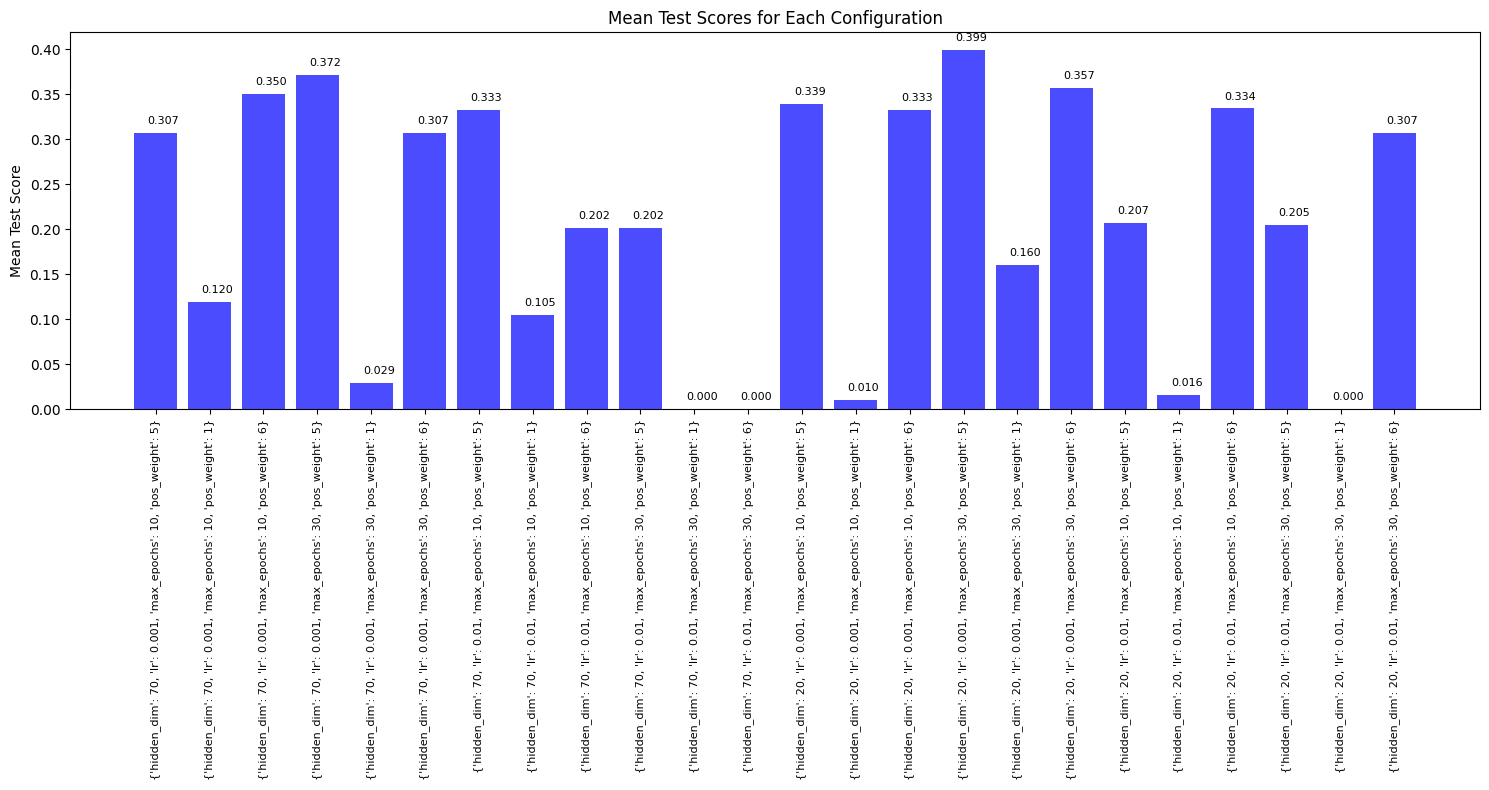

In [8]:
trainer.plot_results()

# 2. Optuna optimisation

[**Optuna**](https://optuna.org/) is an open-source hyperparameter optimization library for machine learning. It automates the process of searching for the best hyperparameter configurations to enhance model performance. Commonly used with frameworks such as TensorFlow, PyTorch, and Scikit-Learn, Optuna employs a Bayesian optimization approach to efficiently explore the hyperparameter space.

For more information, you can check the [official Optuna documentation](https://optuna.readthedocs.io/en/stable/).


**MEDfl** integrates optuna for the optimisation of the initial model of the traning, it offers the functionalities of Optuna to be used on both centralised and federated mode 

to use the Optuna optimisation with MEDfl the you have to: 

1. Specify the optimisation direction: the optimisation direction tell the direction on which we optimise the objective function, it can be `maximize` or `minimize`
2. Specify the optimization metric: the optimisation metric is the value on which the algorithm should optimize 
3. define the hyperparameters of the optimisation
4. start the optimisation 
5. visualize the results of the optimisation 
6. find the best threshold for the optimized model 
7. Test the final model 
8. save the final model 

<img src='../Images/optuna_optim_diag.png' />



### Specify the optimisation direction

In [9]:
direction = 'maximize'

### define the hyperparameters for the optimisation

In [10]:
optuna_params = {
    'num_layers': {'low': 1, 'high': 10},
    'hidden_size': {'low': 17, 'high': 75},
    'num_epochs': {'low': 50, 'high': 200},
    'learning_rate': {'low': 1e-5, 'high': 1e-1, 'log': True},
    'optimizer': ['Adam', 'SGD', 'RMSprop'],
    'n_trials': 300,
    'batch_size' : {'low': 8, 'high': 256}
}

### Start the optimisation
To sart the optimisation we will use the methode optuna_optimisation of the class ParamsOptimizer that take two main arguments 

In [11]:
# start Optuna_optimisation
study = trainer.optuna_optimisation(direction=direction , params=optuna_params)

[I 2024-03-06 16:28:41,311] A new study created in memory with name: no-name-314403f7-5e58-4465-8763-ae20594b9ef4
[I 2024-03-06 16:28:55,320] Trial 0 finished with value: 0.6918722735196724 and parameters: {'batch_size': 225, 'num_layers': 4, 'hidden_size': 56, 'optimizer': 'SGD', 'learning_rate': 0.00047312448952326833, 'num_epochs': 154}. Best is trial 0 with value: 0.6918722735196724.
[I 2024-03-06 16:29:19,142] Trial 1 finished with value: 0.7452247495600096 and parameters: {'batch_size': 134, 'num_layers': 7, 'hidden_size': 33, 'optimizer': 'RMSprop', 'learning_rate': 0.0008004760715824396, 'num_epochs': 172}. Best is trial 1 with value: 0.7452247495600096.
[I 2024-03-06 16:29:29,076] Trial 2 finished with value: 0.730410004253935 and parameters: {'batch_size': 171, 'num_layers': 4, 'hidden_size': 61, 'optimizer': 'SGD', 'learning_rate': 0.00021522680800772535, 'num_epochs': 102}. Best is trial 1 with value: 0.7452247495600096.
[I 2024-03-06 16:29:40,185] Trial 3 finished with val

Best Hyperparameters: {'batch_size': 16, 'num_layers': 6, 'hidden_size': 46, 'optimizer': 'RMSprop', 'learning_rate': 0.0019940796634093597, 'num_epochs': 157}


### Visualize the optimization results 

In [12]:
trainer.plot_optimization_history()

In [13]:
trainer.plot_parallel_coordinate()

In [14]:
trainer.plot_param_importances()

In [15]:
trainer.plot_slice(params=['learning_rate' , 'hidden_size' , 'num_epochs' , 'optimizer'])

In [16]:
trainer.plot_rank(params=["learning_rate"])

/home/local/USHERBROOKE/saho6810/MEDfl/code/MEDfl/Medfl/LearningManager/params_optimiser.py:340: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.



### Find the best threashold for the optimised model 

In [19]:
trainer.optimize_model_threashhold( n_trials=10 , th_min=0.3, th_max=0.6 )

[I 2024-03-07 07:26:01,069] A new study created in memory with name: no-name-4534edf3-1b25-4762-956c-1d63ca38fa67
[I 2024-03-07 07:28:03,831] Trial 0 finished with value: 0.44967880085653106 and parameters: {'threashhold': 0.3025953594197946}. Best is trial 0 with value: 0.44967880085653106.


Final Model F1 Score: 0.44967880085653106


[I 2024-03-07 07:30:09,635] Trial 1 finished with value: 0.44469525959367945 and parameters: {'threashhold': 0.378180314364328}. Best is trial 0 with value: 0.44967880085653106.


Final Model F1 Score: 0.44469525959367945


[I 2024-03-07 07:32:07,435] Trial 2 finished with value: 0.3979721166032953 and parameters: {'threashhold': 0.3110706200533037}. Best is trial 0 with value: 0.44967880085653106.


Final Model F1 Score: 0.3979721166032953


[I 2024-03-07 07:34:07,775] Trial 3 finished with value: 0.3198757763975155 and parameters: {'threashhold': 0.4778721974698665}. Best is trial 0 with value: 0.44967880085653106.


Final Model F1 Score: 0.3198757763975155


[I 2024-03-07 07:36:09,847] Trial 4 finished with value: 0.3067092651757189 and parameters: {'threashhold': 0.4402872933157004}. Best is trial 0 with value: 0.44967880085653106.


Final Model F1 Score: 0.3067092651757189


[I 2024-03-07 07:38:08,277] Trial 5 finished with value: 0.34782608695652173 and parameters: {'threashhold': 0.4128737610094141}. Best is trial 0 with value: 0.44967880085653106.


Final Model F1 Score: 0.34782608695652173


[I 2024-03-07 07:40:11,127] Trial 6 finished with value: 0.3806896551724138 and parameters: {'threashhold': 0.3679434573606523}. Best is trial 0 with value: 0.44967880085653106.


Final Model F1 Score: 0.3806896551724138


[I 2024-03-07 07:42:12,789] Trial 7 finished with value: 0.4046094750320103 and parameters: {'threashhold': 0.49278245358909284}. Best is trial 0 with value: 0.44967880085653106.


Final Model F1 Score: 0.4046094750320103


[I 2024-03-07 07:44:14,612] Trial 8 finished with value: 0.4299287410926365 and parameters: {'threashhold': 0.47140395142673625}. Best is trial 0 with value: 0.44967880085653106.


Final Model F1 Score: 0.4299287410926365


[I 2024-03-07 07:46:16,145] Trial 9 finished with value: 0.218978102189781 and parameters: {'threashhold': 0.5791076724763976}. Best is trial 0 with value: 0.44967880085653106.


Final Model F1 Score: 0.218978102189781
Best Hyperparameters: {'threashhold': 0.3025953594197946}


/home/local/USHERBROOKE/saho6810/MEDfl/code/MEDfl/Medfl/LearningManager/params_optimiser.py:355: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.

